In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:
## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Mg" 
_path = datapath + "bananas/" + iso
above_path = datapath+ "aboveban/" + iso
cuts1 = datapath + "cuts/totcuts.root"
#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
above_files = glob.glob(os.path.join(above_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
}
data_collection = {
    iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Mg: 100%|██████████ 12/12 [00:41<00:00,  3.44s/file]


In [4]:
## loading in cuts and sorting the data to only look into specific cut regions
totcuts = uproot.open(cuts1)

xsa =[]
ysa =[]
for i in ["abovebanU1", "abovebanU2", "abovebanU3", "blank"]:
    if i=="blank":
        xsa.append(0)
        ysa.append(0)
    else:    
        x, y = totcuts[i].values()
        xsa.append(np.array(x)/1e3)
        ysa.append(np.array(y)/1e3)
xs =[]
ys =[]
for i in ["bananaU1", "bananaU2", "bananaU3", "bananaU4"]:
    
    x, y = totcuts[i].values()
    xs.append(np.array(x)/1e3)
    ys.append(np.array(y)/1e3)
   
in_fedep = []
in_bedep = []
in_E = []
above_events = []
above_fedep = []
above_bedep = []
above_E = []
above_fi = []
above_bi = []
in_fi = []
in_bi = []
in_events = []

isotope = iso
for k, i, j, l, h in zip(range(0,4),xs,ys, xsa, ysa):
    det = f"id{k}"
    inbanana = np.column_stack((i, j))
    inbanana_path = Path(inbanana)
    points = np.column_stack((data_collection[isotope][det]["bEdep"], data_collection[isotope][det]["fEdep"]))
    inmask = inbanana_path.contains_points(points)
    in_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[inmask])
    in_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[inmask])
    in_E.append(np.array(data_collection[isotope][det]["E"])[inmask])
    in_fi.append(np.array(data_collection[isotope][det]["FI"])[inmask])
    in_bi.append(np.array(data_collection[isotope][det]["BI"])[inmask])
    in_events.append(len(in_fedep[k]))
    if k!=3:
        abovebanana = np.column_stack((l, h))
        abovebanana_path = Path(abovebanana)
        abovemask = abovebanana_path.contains_points(points)
        above_E.append(np.array(data_collection[isotope][det]["E"])[abovemask])
        above_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[abovemask])
        above_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[abovemask])
        above_fi.append(np.array(data_collection[isotope][det]["FI"])[abovemask])
        above_bi.append(np.array(data_collection[isotope][det]["BI"])[abovemask]) 
        above_events.append(len(above_fedep[k]))

    else:
        continue
    

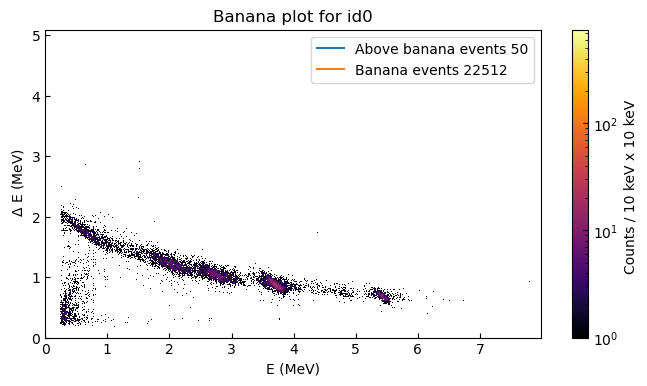

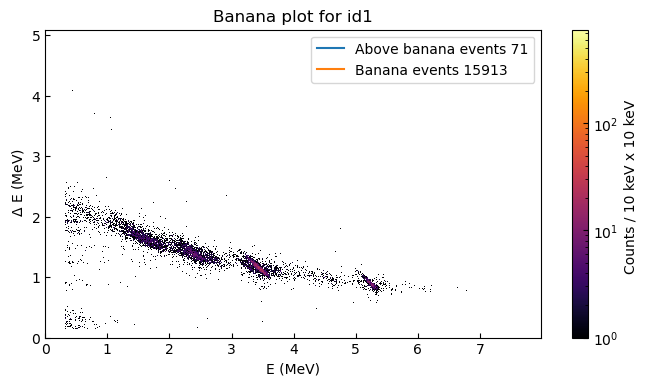

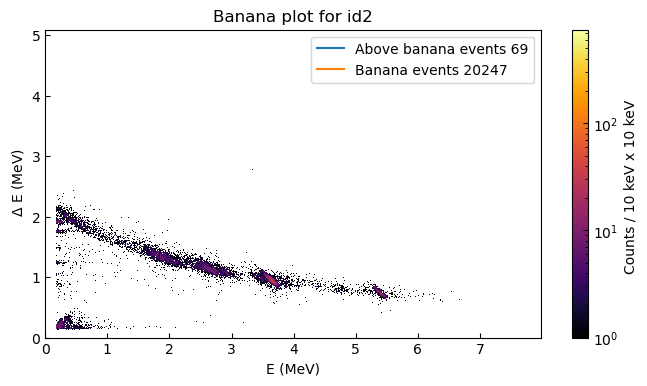

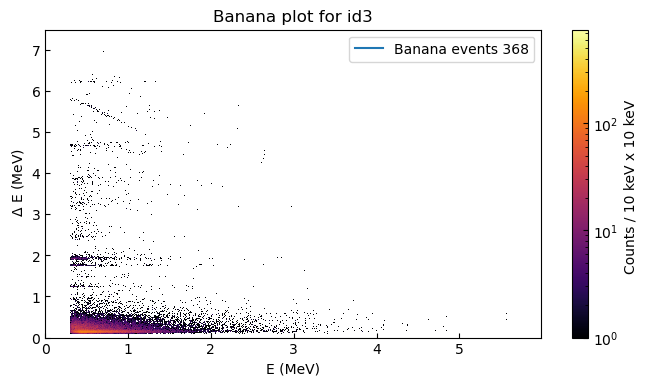

In [6]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

### Banana plots to get an idea of the amount of events above the banana
## An idea of the size of the anomalous events
for i in range(4):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    if i!=3:
        plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
        plt.plot([], [], label=f"Above banana events {above_events[i]}")
    else:
        plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 6, 0.01), np.arange(0, 7.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)   
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.plot([], [], label=f"Banana events {in_events[i]}")
    plt.legend(loc='upper right')
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for {det}")

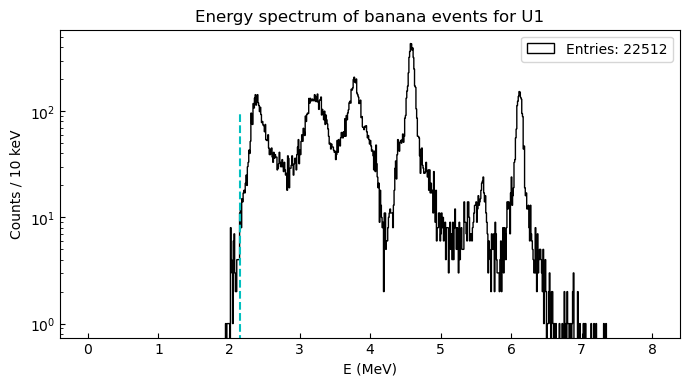

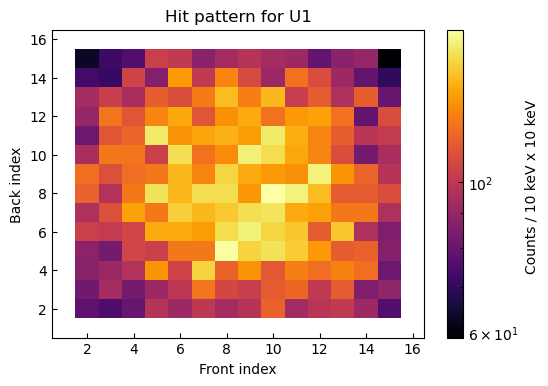

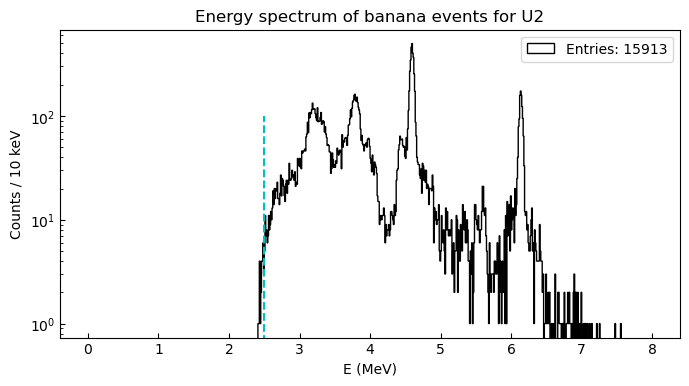

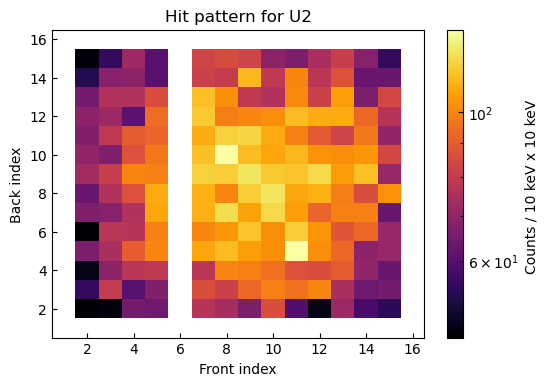

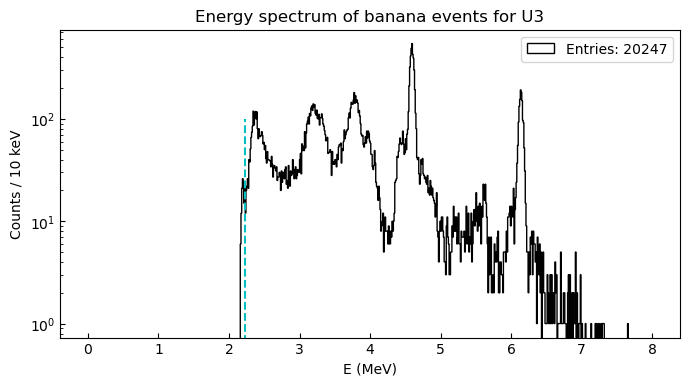

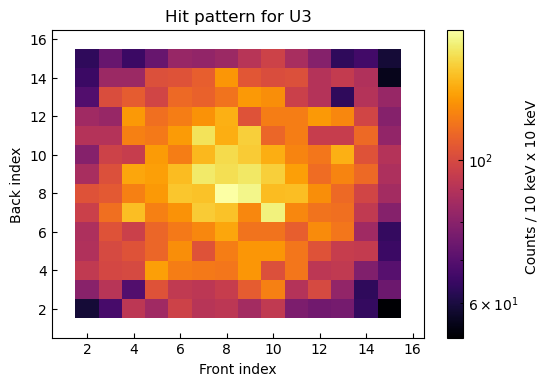

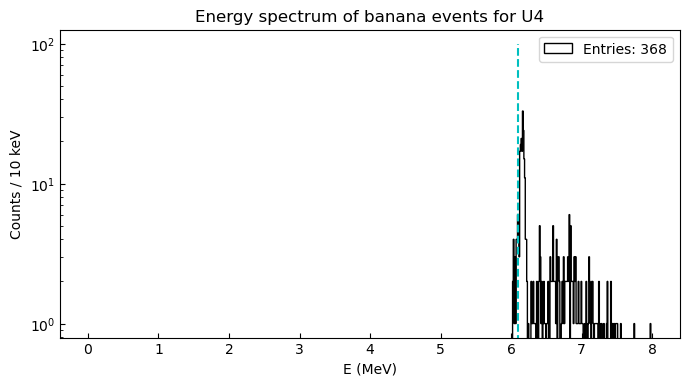

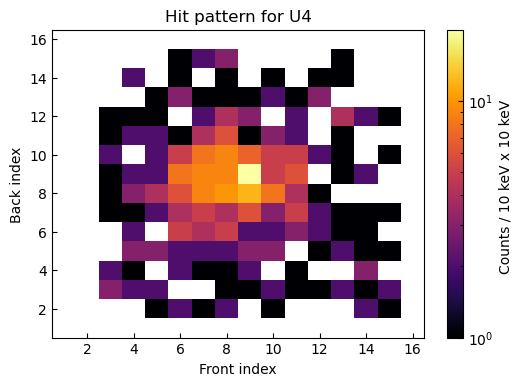

In [43]:
lims = [2.15, 2.5, 2.22, 6.1]
for i in range(4):
    det = f"id{i}"
    k = [a+b for a,b,c,d in zip(in_fedep[i],in_bedep[i], in_fi[i], in_bi[i])]
    plt.figure(figsize=(8,4))
    plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
    æ = np.array(data_collection[iso][det]["Edep"])
    #plt.hist(æ[æ>0], bins=np.arange(0,8, 0.01), histtype='step', color='r', label=f"Entries: {len(æ)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.title(f"Energy spectrum of banana events for U{i+1}")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    
    
    plt.vlines(lims[i], 0,1e2, color='c', ls='--')
    
    
    plt.figure(figsize=(6,4))
    plt.hist2d(in_fi[i]-0.5, in_bi[i]-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for U{i+1}")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')


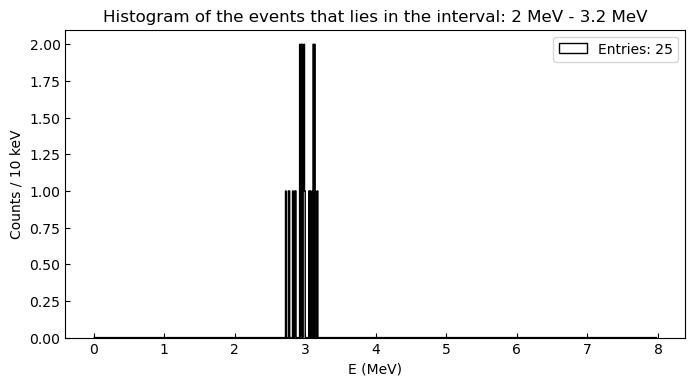

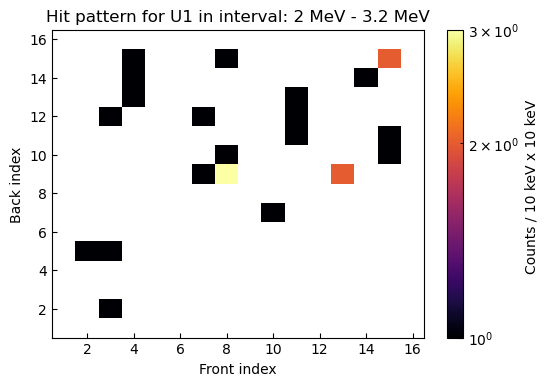

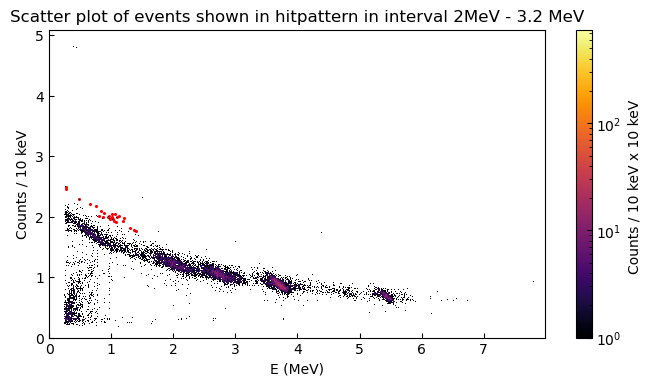

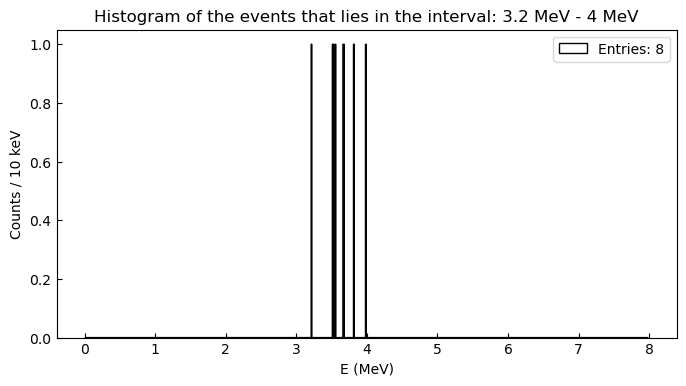

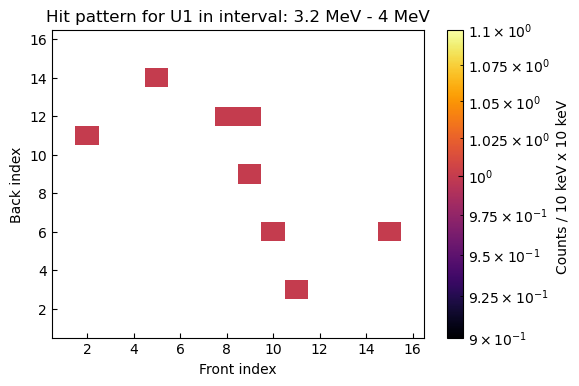

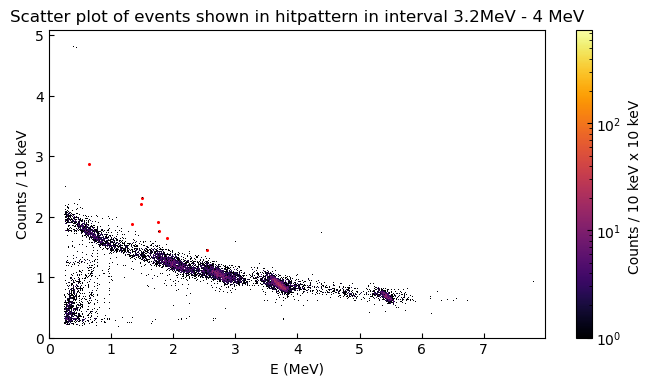

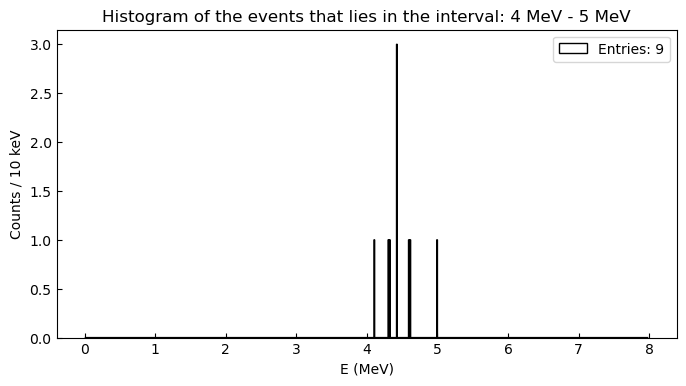

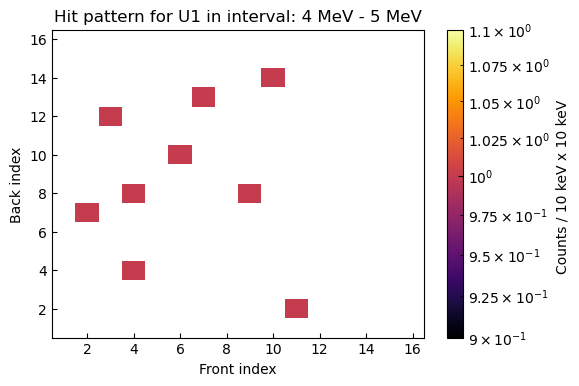

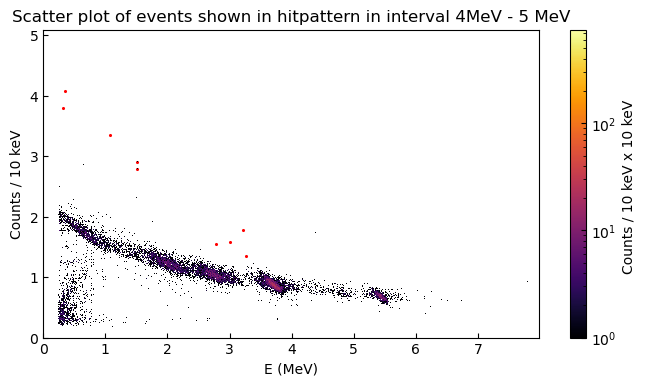

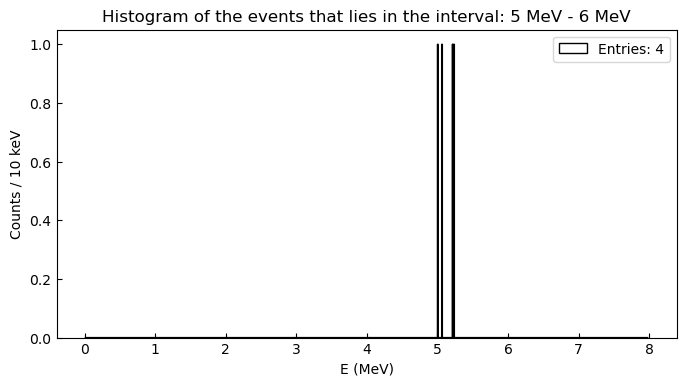

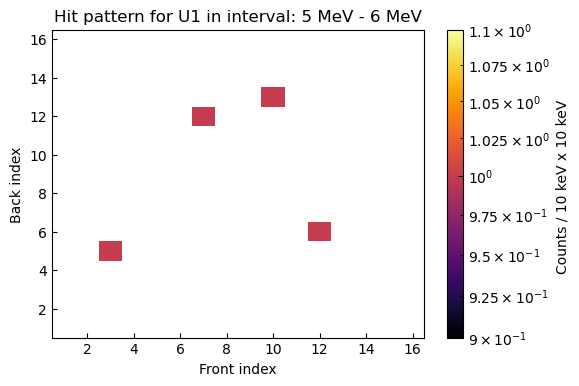

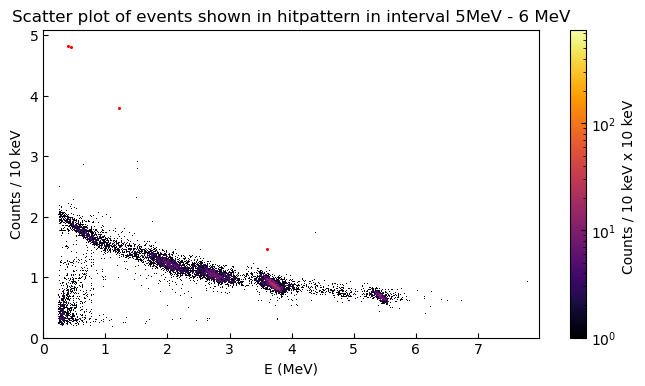

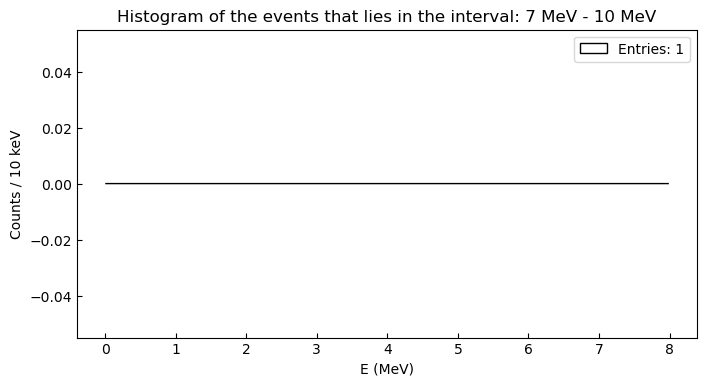

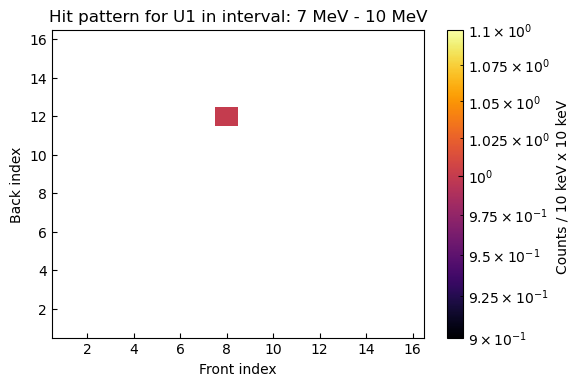

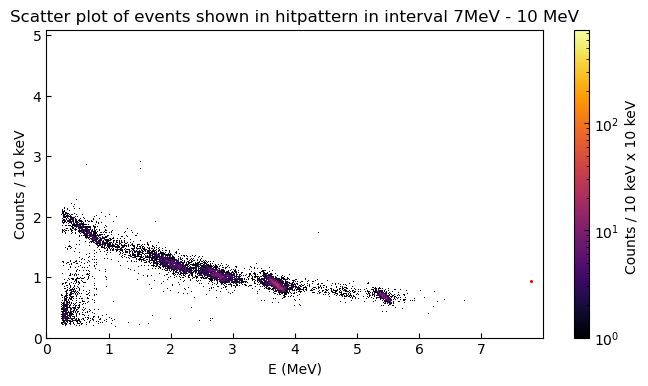

In [8]:
Eints = [(2,3.2),(3.2, 4),(4,5),(5,6),(7,10)]
for j in Eints:
    i = 0
    k = [a+b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.figure(figsize=(8,4))
    plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.title(f"Histogram of the events that lies in the interval: {j[0]} MeV - {j[1]} MeV")
    plt.figure(figsize=(6,4))
    f = [c-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    b = [d-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for U{i+1} in interval: {j[0]} MeV - {j[1]} MeV")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.figure(figsize=(8,4))
    g = [b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    h = [a for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.scatter(g, h, s=1.5, color='r')
    plt.hist2d(data_collection[iso]["id0"]["bEdep"], data_collection[iso]["id0"]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        
    plt.title(f"Scatter plot of events shown in hitpattern in interval {j[0]}MeV - {j[1]} MeV")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")


89


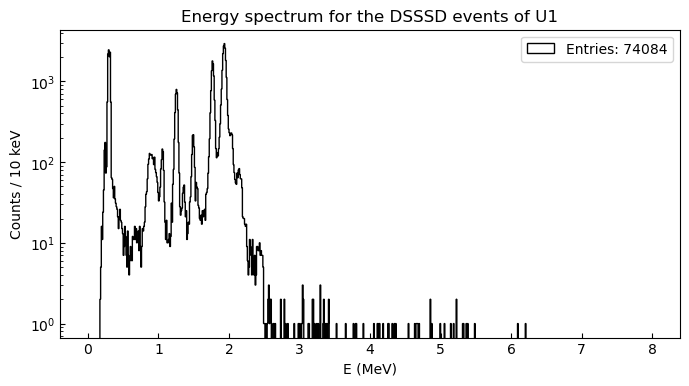

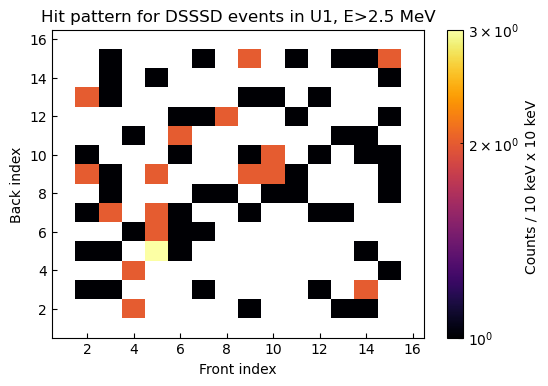

In [61]:
for i in range(1):
    det = f"id{i}"
    #k = [a+b for a,b,c in zip(above_fedep[i],above_bedep[i], above_fi[i]) if c<7]
    k = [a for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["FI"],data_collection[iso][det]["BI"]) if 2.5<a<3.1]
    f = [b-0.5 for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["FI"],data_collection[iso][det]["BI"]) if 2.5<a]
    b = [b-0.5 for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["BI"],data_collection[iso][det]["FI"]) if 2.5<a]
    æ = np.array(data_collection[iso][det]["Edep"])
    plt.figure(figsize=(8,4))
    plt.hist(æ[æ>0], bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(æ)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title(f"Energy spectrum for the DSSSD events of U{i+1}")
    
    plt.figure(figsize=(6,4))
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for DSSSD events in U{i+1}, E>2.5 MeV")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    print(len(f))

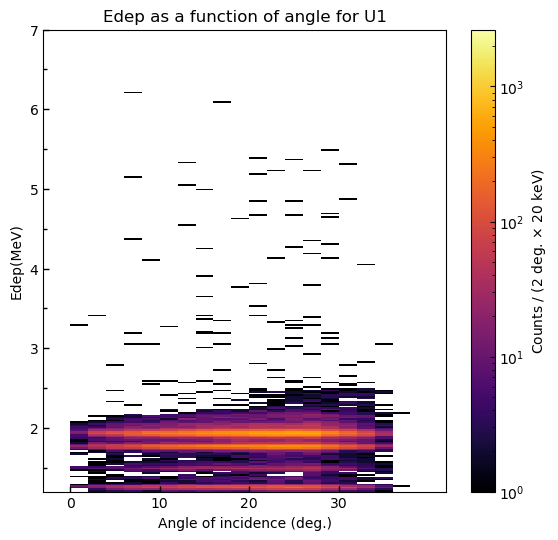

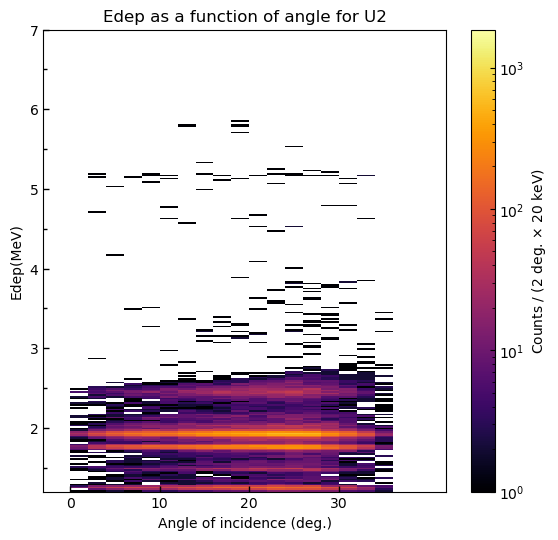

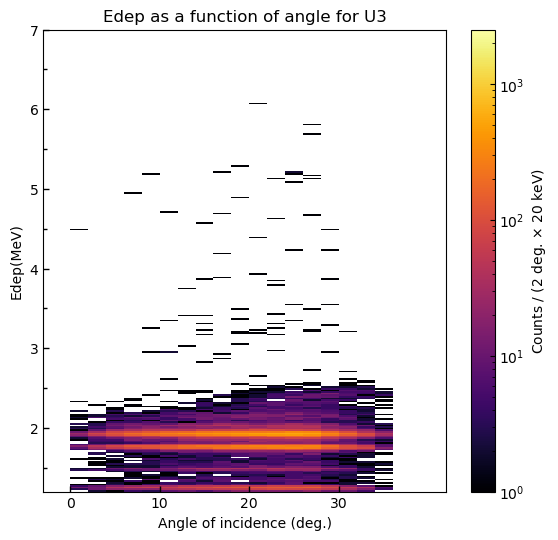

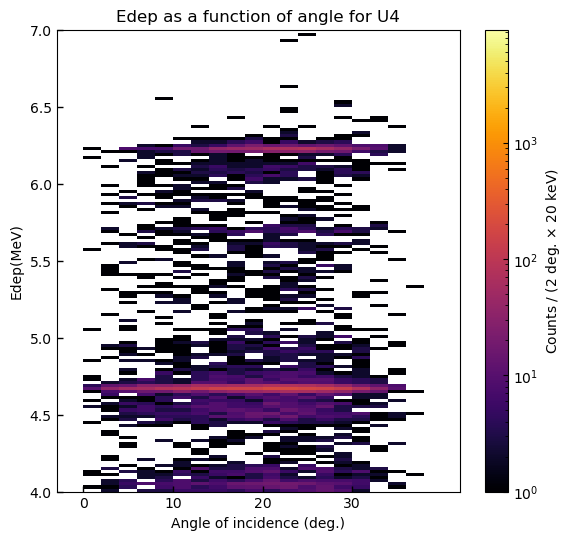

In [63]:
for i in range(0,4):
    det = f"id{i}"
    plt.figure(figsize=(6.5,6))
    a = data_collection[iso][det]["angle"]
    e = data_collection[iso][det]["Edep"]
    plt.hist2d(a, e, bins=(np.arange(0, 42, 2), np.arange(0, 7, 0.02)), 
               cmap=plt.cm.inferno, norm=mpl.colors.LogNorm())
    cbar = plt.colorbar()
    cbar.set_label('Counts / (2 deg. $\\times$ 20 keV)')
    
    ##Formatting of figures
    plt.xticks(np.arange(0, 40, 10))
    plt.xlim(-3, 42)
    plt.tick_params(axis='y', which='major', direction='in', length=4, width=1)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=4, width=1)
    plt.gca().set_yticks(np.arange(0, 7.5, 0.5), minor=True)
    plt.xlabel("Angle of incidence (deg.)")
    plt.ylabel("Edep(MeV)")
    plt.title(f"Edep as a function of angle for U{i+1}", fontsize=12)
    if(i==3):
        plt.ylim(4., 7.)
    else: 
        plt.ylim(1.2, 7.)

Peak intervals:  (1.6, 2.1) (3.1, 3.5) (3.6, 4.1) (4.5, 4.8) (5.95, 6.45)

Telescope 1 counts for each of the peaks: [28980, 4058, 4749, 4893, 1765]

Telescope 2 counts for each of the peaks: [23290, 3352, 3845, 4079, 1368]

Telescope 3 counts for each of the peaks: [25721, 3664, 4340, 4525, 1587]

Telescope 4 counts for each of the peaks:  00, 00 [4107, 4206, 1432]

Difference in % between 1 and 2 is:  [20.0, 17.0, 19.0, 17.0, 22.0]
Difference in % between 1 and 3 is:  [11.0, 10.0, 9.0, 8.0, 10.0]

Difference in % between 4 and 2 is:  ['0', '0'] [6.0, 3.0, 4.0]
Difference in % between 4 and 3 is:  ['0', '0'] [-6.0, -8.0, -11.0]

Difference in % between 4 and 1 is:  ['0', '0'] [-16.0, -16.0, -23.0]
Difference in % between 2 and 3 is:  [-10.0, -9.0, -13.0, -11.0, -16.0]


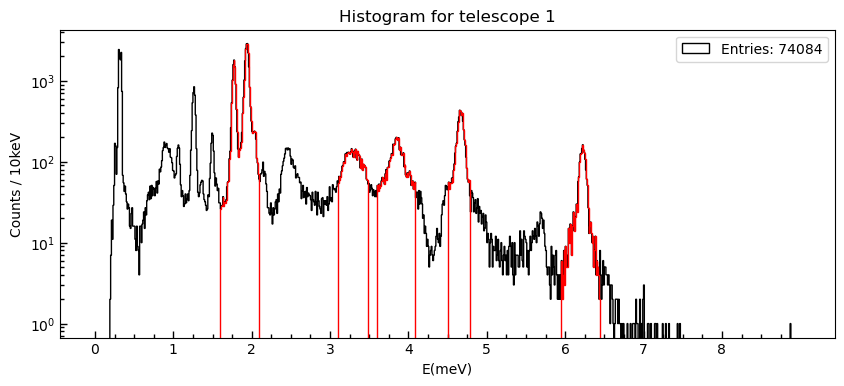

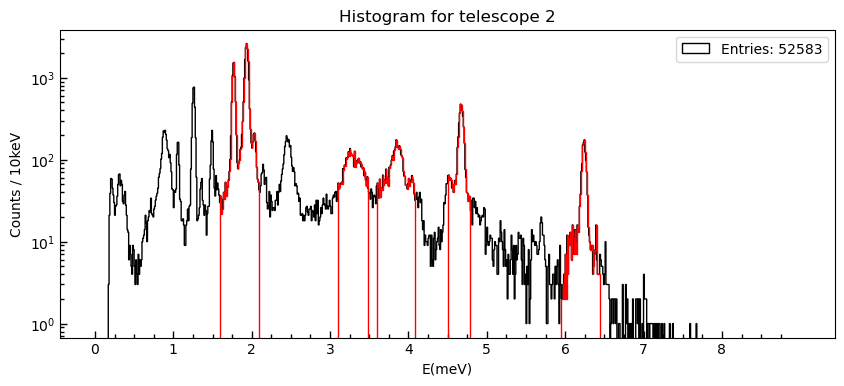

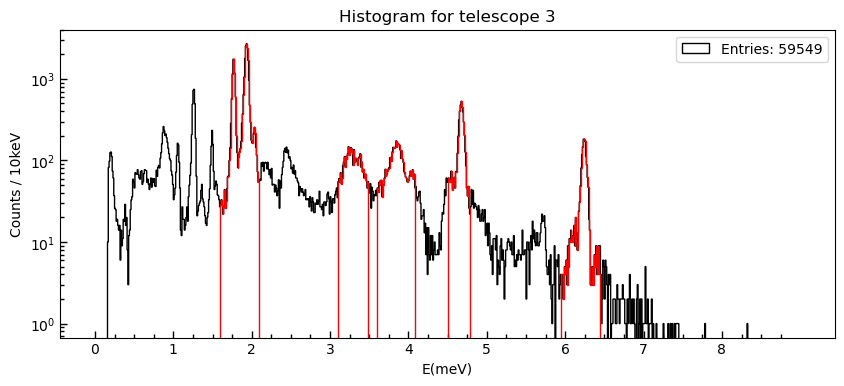

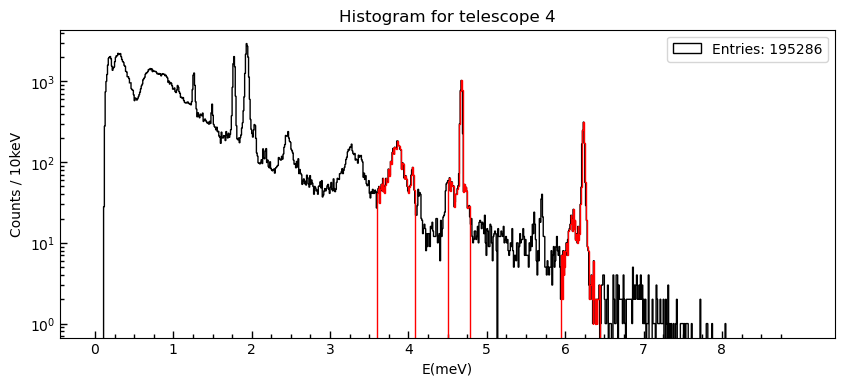

In [57]:
## looking at E & Edep
## Start by only looking at events that have been telescope "verified"
# This means that our data does not contain counts from delta contained events.
#This should also take into account the alpha peaks actually...

peak_intervals = [(1.6,2.1),(3.1, 3.5), (3.6, 4.1),(4.5, 4.8), (5.95,6.45)]

id3peaks = peak_intervals[2:]
counts = [[[] for _ in range(len(peak_intervals))] for _ in range(3)]
counts_id3 = [[] for _ in range(len(id3peaks))]

bin_width = 0.01 #keV

for i in range(4):
    det = f"id{i}"
    bins = np.arange(0, 9, bin_width)
    plt.figure(figsize=(10,4))
    e = np.array(data_collection[iso][det]["E"])
    plt.hist(e, bins=bins, histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.legend()
    if(i==3):
        for int, j in zip(id3peaks, range(len(id3peaks))):
            e_peak = e[(e>int[0]) & (e<int[1])]
            counts_id3[j] = len(e_peak)
            bins = np.arange(int[0], int[1], bin_width)
            plt.hist(e_peak, bins=bins, histtype='step', color='r')
            
    else:
        for int, j in zip(peak_intervals, range(len(peak_intervals))):
            e_peak = e[(e>int[0]) & (e<int[1])]
            counts[i][j] = len(e_peak)
            bins = np.arange(int[0], int[1], bin_width)
            plt.hist(e_peak, bins=bins, histtype='step', color='r')
    plt.title(f"Histogram for telescope {i+1}")
    plt.yscale('log')
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    plt.gca().set_xticks(np.arange(0, 9, 0.25), minor=True)
    plt.xticks(np.arange(0,9,1))
    plt.ylabel("Counts / 10keV")
    plt.xlabel("E(meV)")

print("Peak intervals: ", *peak_intervals)
print()

for i in range(0,4):
    if(i==3):
         print(f"Telescope {i+1} counts for each of the peaks: ",
            "00, 00", [j for j in counts_id3])
    else:        
        print(f"Telescope {i+1} counts for each of the peaks:",
          [j for j in counts[i]])
        print()
print()
print("Difference in % between 1 and 2 is: ", [np.round((i-j)/i*100) for i,j in zip(counts[0],counts[1])])
print("Difference in % between 1 and 3 is: ", [np.round((i-j)/i*100) for i,j in zip(counts[0],counts[2])])
print()
print("Difference in % between 4 and 2 is: ", ["0", "0"],[np.round((i-j)/i*100) for i,j in zip(counts_id3,counts[1][2:])])
print("Difference in % between 4 and 3 is: ", ["0", "0"],[np.round((i-j)/i*100) for i,j in zip(counts_id3,counts[2][2:])])
print()
print("Difference in % between 4 and 1 is: ", ["0", "0"],[np.round((i-j)/i*100) for i,j in zip(counts_id3,counts[0][2:])])
print("Difference in % between 2 and 3 is: ", [np.round((i-j)/i*100) for i,j in zip(counts[1],counts[2])])


Solid angle coverage of the pixels of interest:  2.9766435471239294 %
